# TP6.6 - Construire des modèles complexes (Approche fonctionnelle)

Keras propose une API qui permet de construire des modèles de DNN complexe en se basant sur une modélisation fonctionnelle.</br>
Le modèle fonctionnelle est assez simple à appréhender, on l'écrit comme une fonction mathématique:

$ x=tf.keras.layers.Input(10), y=f(x); z=(g(y); u=concat(f(x),g(y))$</br>
Prenons par exemple le modèle: la couche de normalisation est concaténée avec la couche hidden 2.
<figure>
    <img src="../images/functionalModel.jpg"  style="width:240px;height:300px;" >
</figure>

input_ = tf.keras.layers.Input(X_train.shape[1])</br>
normalized_input = tf.keras.layers.Normalization()(input_)</br>
hidden1 = tf.keras.layers.Dense(????, activation="???")(normalized_input)</br>
hidden2 = tf.keras.layers.Dense(????, activation="????")(hidden1)</br>
concat = tf.keras.layers.Concatenate()([normalized_input, hidden2])</br>
output = tf.keras.layers.Dense(1, activation="sigmoid")(concat)</br>



model = tf.keras.Model(inputs=[input_], outputs=[output])</br></br>



On peut construire aisément des architectures sophistiquées. 
- On peut imaginer par exemple que les hidden couches 1 et 2 sont concaténées. 
- la Hidden 1 est remise à la sortie de hidden 1. 

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
import keras_tuner as kt

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [77]:
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    # Define the true positives, false positives and false negatives
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    # Calculate the precision and recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Calculate the F1 score
    f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    return f1_score

## Réseaux de neurones avec une sortie sigmoide  sigmoïde


### 1 Le DataSet
On utilisera le Dataset smoking, 

In [78]:
# Lecture du dataset n permet de limiter le nombre de lignes à lire
# Pour faciliter les tests
import pandas as pd
def load_data(n):
    data = pd.read_csv('../data/train.new.csv')
    return data[0:n]
genders = {
    'M' : 0,
    'F' : 1
}
def select_variables(df):
    df = df.dropna()
    df = df.drop('id', axis=1)
    df = df.drop('country', axis=1)
    df = df.replace(genders)
    df['imc'] = df['weight(kg)'] / (df['height(cm)'] / 100) ** 2
    #make some categorical variables
    df['new_age'] = pd.cut(df['age'], 5, labels=False)
    df['eyesight(right)'] = pd.cut(df['eyesight(right)'], 5, labels=False)
    df['eyesight(left)'] = pd.cut(df['eyesight(left)'], 5, labels=False)
    #make combinations of categorical variables
    df['age_bmi'] = df['new_age'] * df['imc']
    X = df.drop('smoking', axis=1)
    y = df['smoking']
    X = X.drop('age', axis=1)
    return X, y



## 2 Préparation des données

#### 2.1. Split des données 

In [79]:
def split_data(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test  

In [80]:
## On peut utiliser une simple normalisation (x-mu)/ecart type)
def normaliser(X_train, X_test):
    mean = X_train.mean()
    std  = X_train.std()
    X_train = (X_train - mean) / std
    X_test  = (X_test  - mean) / std

    return X_train, X_test 

In [81]:
# Préparation ds données
# le -1 du load_data(-1) veut dire on prend toutes les lignes 
data=load_data(-1)
# sélectionner les variables
X,y = select_variables(data)
X_train, X_test, y_train, y_test = split_data(X,y)
X_train, X_test = normaliser(X_train, X_test)
print("X_train.shape", X_train.shape, "X_test.shape", X_test.shape)

X_train.shape (109299, 25) X_test.shape (27325, 25)


## 3. Définition du modèle de régression linaire

On définit un modèle avec deux branches
- une branche : une réseau à 2 couches  à 50 neurones avec un relu
- une branche : un réseau 

#### 3.1 Un réseau de neurones complexe à plusieurs couches

In [87]:

input_ = tf.keras.layers.Input(X_train.shape[1])
concat1 = tf.keras.layers.Dense(256, activation='relu')(input_)
dropout_layer = tf.keras.layers.Dropout(0.2)(concat1)
concat2 = tf.keras.layers.Dense(128, activation='relu')(dropout_layer)
concatenated = tf.keras.layers.Concatenate()([concat1, concat2])
batch_norm1 = tf.keras.layers.BatchNormalization()(concatenated)
dropout = tf.keras.layers.Dropout(0.2)(batch_norm1)
hiden_1 = tf.keras.layers.Dense(32, activation='relu')(dropout)
batch_norm2 = tf.keras.layers.BatchNormalization()(hiden_1)
output = tf.keras.layers.Dense(1, activation='sigmoid')(batch_norm2)
model = tf.keras.Model(inputs=input_, outputs=output)
#Compiler le modèle
model.compile(optimizer='adam',
              loss= 'BinaryCrossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 25)]                 0         []                            
                                                                                                  
 dense_4 (Dense)             (None, 256)                  6656      ['input_2[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 256)                  0         ['dense_4[0][0]']             
                                                                                                  
 dense_5 (Dense)             (None, 128)                  32896     ['dropout_2[0][0]']           
                                                                                            

### 4. Entrainement du modèle (Model training)

In [92]:
def build_model(hp:kt.HyperParameters):
    activations = ['relu', 'mish']
    dropout_value = hp.Float('dropout', 0.0, 0.5, step=0.1)
    input_ = tf.keras.layers.Input(X_train.shape[1])
    concat1 = tf.keras.layers.Dense(hp.Int(name="concat1unit", min_value=120, max_value=250, step=20), activation=hp.Choice(name='activationFirstLayer', values=activations))(input_)
    dropout_layer = tf.keras.layers.Dropout(dropout_value)(concat1)
    concat2 = tf.keras.layers.Dense(hp.Int(name='concat2_nbUnits',min_value=40, max_value=120, step=20), activation=hp.Choice(name='activationConcat2', values=activations))(dropout_layer)
    concatenated = tf.keras.layers.Concatenate()([concat1, concat2])
    batch_norm1 = tf.keras.layers.BatchNormalization()(concatenated)
    dropout = tf.keras.layers.Dropout(dropout_value)(batch_norm1)
    hiden_1 = tf.keras.layers.Dense(hp.Int(name='hiden1_nbUnits',min_value=10, max_value=50, step=10), activation=hp.Choice(name="last_hiden_activation", values=activations))(dropout)
    batch_norm2 = tf.keras.layers.BatchNormalization()(hiden_1)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(batch_norm2)
    model = tf.keras.Model(inputs=input_, outputs=output)
    #Compiler le modèle
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss= 'BinaryCrossentropy',
              metrics=['accuracy'])
    return model

In [93]:
patience_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [94]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    executions_per_trial=2,
    directory='train_smoking',
    project_name='v2',
    overwrite=True)


In [95]:
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[patience_callback])

Trial 30 Complete [00h 04m 22s]
val_accuracy: 0.7749679684638977

Best val_accuracy So Far: 0.775480329990387
Total elapsed time: 00h 55m 57s


In [96]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 240)                  6240      ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 240)                  0         ['dense[0][0]']               
                                                                                                  
 dense_1 (Dense)             (None, 60)                   14460     ['dropout[0][0]']             
                                                                                              

In [97]:
# Entrainement du modele
history  = model.fit(X_train, 
                     y_train, 
                     epochs=20, 
                     batch_size= 32, 
                     verbose=False,
                     validation_data = (X_test, y_test))
#model.metrics_names

### 5. Evaluation des performances du modèle 
Utilisation de  MAE = Mean Absolute Error (between the labels and predictions), 
la loss, le R2 score 


In [98]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss     :', score[0])
print('Test accuracy :', score[1])
#print('Test f1 score :', score[2])

Test loss     : 0.45714250206947327
Test accuracy : 0.7718572616577148


### Historique du Training (training history)
Quel était le meilleur résultat prendant l'entrainement

In [99]:
print(history.params)
print(history.history.keys())
#print(history.history['loss'])

{'verbose': False, 'epochs': 20, 'steps': 3416}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [100]:
import pandas as pd 
df=pd.DataFrame(data=history.history)
display(df)

,loss,accuracy,val_loss,val_accuracy
0,0.461127,0.768836,0.455658,0.774785
1,0.461529,0.769495,0.456445,0.773504
2,0.460534,0.771544,0.454769,0.772662
3,0.459283,0.770355,0.455743,0.771125
4,0.458447,0.771526,0.456362,0.773651
5,0.458171,0.772596,0.454018,0.773211
6,0.457344,0.772907,0.456466,0.772626
7,0.457697,0.772047,0.455830,0.773577
8,0.455674,0.773850,0.457129,0.773211
9,0.454939,0.773557,0.456889,0.773175


Text(0.5, 1.0, 'Accuracy ')

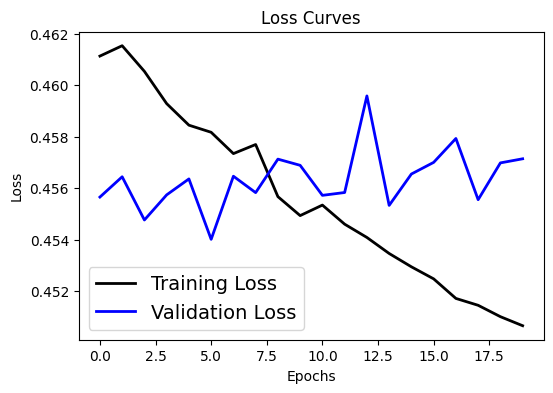

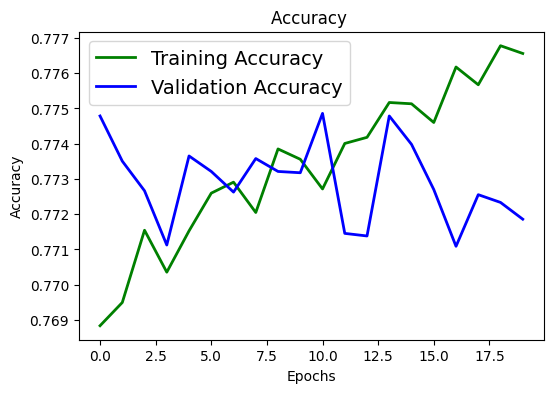

In [101]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

# Plotting the Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'green', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy ', fontsize=12)


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(X_test)

# Predict probabilities
y_pred = model.predict(X_test)

# Get class labels
y_classes = np.argmax(y_pred, axis=-1)
#y_classes = np.where(predictions > 0.5, 1, 0)

cm = confusion_matrix(y_test, y_classes)
#disp= ConfusionMatrixDisplay(confusion_matrix=cm)

sns.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()


### Save History and model

In [ ]:
#Saving:

np.save('my_history_sd_1n.npy',history.history)
#np.save('my_history_sd_MLP.npy',history.history)
#np.save('my_history_Ld_1n.npy',history.history)
#np.save('my_history_Ld_MLP.npy',history.history)

In [ ]:
#Loading:
history=np.load('my_history.sd_1n.npy',allow_pickle='TRUE').item()


### 6. Faire des prédictions

In [ ]:
#Small Sata set
my_data = [ -0.25, -0.75, 0.78]
survived = 0
my_data=np.array(my_data).reshape(1,3)


In [ ]:
predictions = model.predict( my_data )
print("Prediction : {:.2f} K$".format(predictions[0][0]))
print("Reality    : {:.2f} K$".format(survived))


## Question:
- Comparer les deux modèles (simple versus complexe)